# Импорт модулей

In [ ]:
# Подавление предупреждений
import warnings
for warn in [UserWarning, FutureWarning]: warnings.filterwarnings("ignore", category = warn)

# Импорт необходимых библиотек
import kagglehub
import os
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import polars as pl
import pandas as pd
import sklearn
import networkx as nx
import ipywidgets
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import string
import re
import nltk
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer

from torch import Tensor
from einops import rearrange
from typing import Tuple, Callable
from torch.autograd import Function
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
SEED = 42
BATCH_SIZE = 16
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE

device(type='cpu')

# Класс модели xLSTM и её надстройка

In [ ]:
class CausalConv1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation=1, **kwargs):
        super(CausalConv1D, self).__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_channels, out_channels, kernel_size, padding=self.padding, dilation=dilation, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return x[:, :, :-self.padding]

class BlockDiagonal(nn.Module):
    def __init__(self, in_features, out_features, num_blocks):
        super(BlockDiagonal, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.num_blocks = num_blocks
        self.blocks = nn.ModuleList([nn.Linear(in_features // num_blocks, out_features // num_blocks) for _ in range(num_blocks)])

    def forward(self, x):
        x = x.chunk(self.num_blocks, dim=-1)
        x = [block(x_i) for block, x_i in zip(self.blocks, x)]
        return torch.cat(x, dim=-1)

class sLSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, proj_factor=4/3, dropout_prob=0.3):
        super(sLSTMBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads  # Initialize head_size
        self.proj_factor = proj_factor
        self.layer_norm = nn.LayerNorm(input_size)
        self.causal_conv = CausalConv1D(1, 1, 4)
        self.Wz = BlockDiagonal(input_size, hidden_size, num_heads)
        self.Wi = BlockDiagonal(input_size, hidden_size, num_heads)
        self.Wf = BlockDiagonal(input_size, hidden_size, num_heads)
        self.Wo = BlockDiagonal(input_size, hidden_size, num_heads)
        self.Rz = BlockDiagonal(hidden_size, hidden_size, num_heads)
        self.Ri = BlockDiagonal(hidden_size, hidden_size, num_heads)
        self.Rf = BlockDiagonal(hidden_size, hidden_size, num_heads)
        self.Ro = BlockDiagonal(hidden_size, hidden_size, num_heads)
        self.group_norm = nn.GroupNorm(num_heads, hidden_size)
        self.up_proj_left = nn.Linear(hidden_size, int(hidden_size * proj_factor))
        self.up_proj_right = nn.Linear(hidden_size, int(hidden_size * proj_factor))
        self.down_proj = nn.Linear(int(hidden_size * proj_factor), hidden_size)
        self.dropout = nn.Dropout(dropout_prob)  # Added dropout

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state
        x_norm = self.layer_norm(x)
        x_conv = F.silu(self.causal_conv(x_norm.unsqueeze(1)).squeeze(1))
        z = torch.tanh(self.Wz(x) + self.Rz(h_prev))
        o = torch.sigmoid(self.Wo(x) + self.Ro(h_prev))
        i_tilde = self.Wi(x_conv) + self.Ri(h_prev)
        f_tilde = self.Wf(x_conv) + self.Rf(h_prev)
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)
        c_t = f * c_prev + i * z
        n_t = f * n_prev + i
        h_t = o * c_t / n_t
        output = h_t
        output_norm = self.group_norm(output)
        output_left = self.up_proj_left(output_norm)
        output_right = self.up_proj_right(output_norm)
        output_gated = F.gelu(output_right)
        output = output_left * output_gated
        output = self.down_proj(output)
        output = self.dropout(output)  # Apply dropout
        return output + h_prev, (h_t, c_t, n_t, m_t)

class mLSTMBlock(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, proj_factor=2, dropout_prob=0.3):
        super(mLSTMBlock, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_heads = num_heads
        self.head_size = hidden_size // num_heads  # Initialize head_size
        self.proj_factor = proj_factor

        self.layer_norm = nn.LayerNorm(input_size)
        self.up_proj_left = nn.Linear(input_size, int(input_size * proj_factor))
        self.up_proj_right = nn.Linear(input_size, hidden_size)
        self.down_proj = nn.Linear(hidden_size, hidden_size)
        self.causal_conv = CausalConv1D(1, 1, 4)
        self.skip_connection = nn.Linear(int(input_size * proj_factor), hidden_size)
        self.Wq = BlockDiagonal(int(input_size * proj_factor), hidden_size, num_heads)
        self.Wk = BlockDiagonal(int(input_size * proj_factor), hidden_size, num_heads)
        self.Wv = BlockDiagonal(int(input_size * proj_factor), hidden_size, num_heads)
        self.Wi = nn.Linear(int(input_size * proj_factor), hidden_size)
        self.Wf = nn.Linear(int(input_size * proj_factor), hidden_size)
        self.Wo = nn.Linear(int(input_size * proj_factor), hidden_size)
        self.group_norm = nn.GroupNorm(num_heads, hidden_size)
        self.dropout = nn.Dropout(dropout_prob)  # Added dropout

    def forward(self, x, prev_state):
        h_prev, c_prev, n_prev, m_prev = prev_state
        x_norm = self.layer_norm(x)
        x_up_left = self.up_proj_left(x_norm)
        x_up_right = self.up_proj_right(x_norm)
        x_conv = F.silu(self.causal_conv(x_up_left.unsqueeze(1)).squeeze(1))
        x_skip = self.skip_connection(x_conv)
        q = self.Wq(x_conv)
        k = self.Wk(x_conv) / (self.head_size ** 0.5)  # Use self.head_size here
        v = self.Wv(x_up_left)
        i_tilde = self.Wi(x_conv)
        f_tilde = self.Wf(x_conv)
        o = torch.sigmoid(self.Wo(x_up_left))
        m_t = torch.max(f_tilde + m_prev, i_tilde)
        i = torch.exp(i_tilde - m_t)
        f = torch.exp(f_tilde + m_prev - m_t)
        c_t = f * c_prev + i * (v * k)
        n_t = f * n_prev + i * k
        h_t = o * (c_t * q) / torch.max(torch.abs(n_t), torch.tensor(1.0, device=x.device))
        output = h_t
        output_norm = self.group_norm(output)
        output = output_norm + x_skip
        output = output * F.silu(x_up_right)
        output = self.down_proj(output)
        output = self.dropout(output)  # Apply dropout
        return output + h_prev, (h_t, c_t, n_t, m_t)

In [ ]:
class xLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, layers, batch_first=False, proj_factor_slstm=4/3, proj_factor_mlstm=2, dropout_prob=0.3):
        super(xLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.layers = nn.ModuleList()
        for i, layer_type in enumerate(layers):
            if layer_type == 's':
                layer = sLSTMBlock(input_size if i == 0 else hidden_size, hidden_size, num_heads, proj_factor_slstm, dropout_prob=dropout_prob)
            elif layer_type == 'm':
                layer = mLSTMBlock(input_size if i == 0 else hidden_size, hidden_size, num_heads, proj_factor_mlstm, dropout_prob=dropout_prob)
            self.layers.append(layer)

        self.batch_first = batch_first

    def forward(self, x, state=None):
        if self.batch_first:
            x = x.transpose(0, 1)

        if state is not None:
            state = torch.stack(list(state))
            state = state.transpose(0, 1)
        else:
            state = torch.zeros(len(self.layers), 4, x.size(1), self.hidden_size, device=x.device)

        output = []
        for t in range(x.size(0)):
            x_t = x[t]
            for layer in range(len(self.layers)):
                x_t, state_tuple = self.layers[layer](x_t, tuple(state[layer].clone()))
                state[layer] = torch.stack(list(state_tuple))
            output.append(x_t)

        output = torch.stack(output)
        state = tuple(state.transpose(0, 1))

        if self.batch_first:
            output = output.transpose(0, 1)

        return output, state

In [ ]:
# надстройка над xLSTM для задачи классификации
class TextClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_heads, layers, num_classes, batch_first=False, dropout_prob=0.3):
        super(TextClassifier, self).__init__()
        self.xlstm = xLSTM(input_size, hidden_size, num_heads, layers, batch_first=batch_first, dropout_prob=dropout_prob)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x, state=None):
        x, state = self.xlstm(x, state)
        x = x[:, -1, :] if self.xlstm.batch_first else x[-1]
        x = self.dropout(x)
        return self.fc(x)

# Подготовка данных

## Скачиваем

In [ ]:
data_train, data_val = pd.read_csv('twitter_training.csv', names=["id","company","label","text"], dtype={col : 'string' for col in ["id","company","label","text"]}), \
    pd.read_csv('twitter_validation.csv', names=["id","company","label","text"])

In [ ]:
data_train.sample(5)

,id,company,label,text
72127,11156,TomClancysGhostRecon,Positive,Sooooooo keeeeeeeeen
24780,4656,Google,Negative,i will never understand continuing to trust fr...
8021,9377,Overwatch,Positive,utterly beautiful and phenomenal <unk>.
4450,1965,CallOfDutyBlackopsColdWar,Neutral,Black Ops Cold War game ’ s campaign has gone ...
49328,6068,FIFA,Negative,Let's discuss the buffoon that is @ EASPORTSFI...


In [ ]:
data_train, data_val = data_train.drop(["id","company"],axis=1), data_val.drop(["id","company"],axis=1)

## Делаем эмбеддинги

In [ ]:
# @title
nltk.download('stopwords')
nltk.download('wordnet')        # for Lemmatizer
nltk.download('omw-1.4')        # optional, improves lemmatization
nltk.download('punkt')

contractions_dict = {
    "aren't": "are not",
    "can't": "cannot",
    "could've": "could have",
    "couldn't": "could not",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he had",
    "he'll": "he will",
    "he's": "he is",
    "how'd": "how did",
    "how'll": "how will",
    "how's": "how is",
    "I'd": "I had",
    "I'll": "I will",
    "I'm": "I am",
    "I've": "I have",
    "isn't": "is not",
    "it'd": "it had",
    "it'll": "it will",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "might've": "might have",
    "mightn't": "might not",
    "must've": "must have",
    "mustn't": "must not",
    "needn't": "need not",
    "o'clock": "of the clock",
    "she'd": "she had",
    "she'll": "she will",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "that'd": "that would",
    "that's": "that is",
    "there'd": "there had",
    "there's": "there is",
    "they'd": "they had",
    "they'll": "they will",
    "they're": "they are",
    "they've": "they have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'll": "we will",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "where'd": "where did",
    "where's": "where is",
    "who'd": "who had",
    "who'll": "who will",
    "who's": "who is",
    "why'd": "why did",
    "why're": "why are",
    "why's": "why is",
    "won't": "will not",
    "would've": "would have",
    "wouldn't": "would not",
    "you'd": "you had",
    "you'll": "you will",
    "you're": "you are",
    "you've": "you have",
    "ain't": "is not",
    "shan't": "shall not",
}

stop_words = {
    "a", "an", "the", "and", "or", "but", "if", "while", "although", "though", "nor", "so", "yet",
    "either", "neither", "both", "in", "on", "at", "by", "for", "with", "about", "against", "between",
    "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
    "of", "off", "over", "under", "around", "near", "am", "is", "are", "was", "were", "be", "being",
    "been", "have", "has", "had", "do", "does", "did", "will", "would", "shall", "should", "can",
    "could", "may", "might", "must", "I", "me", "you", "he", "him", "she", "her", "it", "we", "us",
    "they", "them", "my", "your", "his", "its", "our", "their", "mine", "yours", "hers", "ours",
    "theirs", "this", "that", "these", "those", "very", "just", "too", "also", "here", "there",
    "then", "now", "when", "where", "why", "how", "again", "ever", "never", "always", "sometimes",
    "often", "seldom", "not", "no", "than", "as", "like", "such", "because", "what", "which",
    "who", "whom", "whose", "etc", "etc.", "per", "via"
}.union(set(stopwords.words("english")))

stemmer=PorterStemmer()
def get_text_new(text):
    text = str(text)
    text = text.lower()
    text = re.sub(r"<[^>]+>", "", text)  # remove HTML tags
    text = re.sub(r"http\S+|www\S+", "", text)  # remove URLs
    text = re.sub(r'\b(' + '|'.join(re.escape(k) for k in contractions_dict.keys()) + r')\b',
                  lambda m: contractions_dict[m.group(0)], text)  # expand contractions
    text = re.sub(rf"[{re.escape(string.punctuation)}]", "", text)  # remove punctuation

    raw = text
    words = text.split()
    stem = [stemmer.stem(word) for word in words if len(word) > 2 and word not in stop_words]

    return pd.Series([" ".join(stem)])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
data_train["text_new"] = data_train["text"].apply(get_text_new)
data_val["text_new"] = data_val["text"].apply(get_text_new)

In [ ]:
X_train, X_val, y_train, y_val = data_train['text_new'], data_val['text_new'], data_train['label'], data_val['label']

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorization = TfidfVectorizer(max_features=10_000)
XV_train = vectorization.fit_transform(X_train)
XV_val = vectorization.transform(X_val)

In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)

## Разбиваем на батчи

In [ ]:
from torch.utils.data import DataLoader, Dataset

class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx].todense(), dtype=torch.float32).to(DEVICE), torch.tensor(self.y[idx], dtype=torch.long).to(DEVICE)

train_dataset = TextDataset(XV_train, y_train_encoded)
val_dataset = TextDataset(XV_val, y_val_encoded)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Обучение модели

In [ ]:
input_size = XV_train.shape[1]
hidden_size = 128
num_heads = 2
num_classes = len(set(y_train_encoded))
learning_rate = 0.00001
num_epochs = 10

model = TextClassifier(input_size, hidden_size, num_heads, "m", num_classes, batch_first=True).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_model(model, optimizer, train_loader, test_loader, num_epochs, save_path='models'):
    os.makedirs(save_path, exist_ok=True)

    train_losses, val_losses, train_accuracies, val_accuracies, epochs = [], [], [], [], []
    best_val_acc = 0.0
    best_model_path = ""
    for epoch in range(num_epochs):
        model.train()
        train_loss, correct, total = 0, 0, 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(x_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

        train_acc = correct / total
        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(train_acc)

        model.eval()
        val_loss, correct, total = 0, 0, 0

        with torch.no_grad():
            for x_batch, y_batch in test_loader:
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)
                outputs = model(x_batch)
                loss = criterion(outputs, y_batch)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += y_batch.size(0)
                correct += (predicted == y_batch).sum().item()

        val_acc = correct / total
        val_losses.append(val_loss / len(test_loader))
        val_accuracies.append(val_acc)
        epochs.append(epoch + 1)

        # Save the model after each epoch
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_path = os.path.join(save_path, f'model_epoch_{epoch + 1}.pth')
            torch.save(model.state_dict(), best_model_path)
            print(f'New best model saved with validation accuracy {val_acc:.4f} to {best_model_path}')

        print(f'Epoch {epoch + 1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Accuracy: {train_accuracies[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Accuracy: {val_accuracies[-1]:.4f}')
    return best_model_path, (train_losses, val_losses, train_accuracies, val_accuracies, epochs)

In [ ]:
best_model_path, train_info = train_model(model, optimizer, train_loader, val_loader, num_epochs)

New best model saved with validation accuracy 0.9440 to models/model_epoch_1.pth
Epoch 1/10, Train Loss: 0.7976, Train Accuracy: 0.6883, Val Loss: 0.2091, Val Accuracy: 0.9440
New best model saved with validation accuracy 0.9580 to models/model_epoch_2.pth
Epoch 2/10, Train Loss: 0.2850, Train Accuracy: 0.8965, Val Loss: 0.1249, Val Accuracy: 0.9580
New best model saved with validation accuracy 0.9640 to models/model_epoch_3.pth
Epoch 3/10, Train Loss: 0.1737, Train Accuracy: 0.9318, Val Loss: 0.1208, Val Accuracy: 0.9640
New best model saved with validation accuracy 0.9680 to models/model_epoch_4.pth
Epoch 4/10, Train Loss: 0.1374, Train Accuracy: 0.9436, Val Loss: 0.1177, Val Accuracy: 0.9680
Epoch 5/10, Train Loss: 0.1230, Train Accuracy: 0.9482, Val Loss: 0.1460, Val Accuracy: 0.9580
Epoch 6/10, Train Loss: 0.1135, Train Accuracy: 0.9511, Val Loss: 0.1405, Val Accuracy: 0.9560
Epoch 7/10, Train Loss: 0.1080, Train Accuracy: 0.9521, Val Loss: 0.1361, Val Accuracy: 0.9650
Epoch 8/10,

In [ ]:
best_model_path_1, train_info_1 = train_model(model, optimizer, train_loader, val_loader, num_epochs)

New best model saved with validation accuracy 0.9580 to models/model_epoch_1.pth
Epoch 1/10, Train Loss: 0.0973, Train Accuracy: 0.9550, Val Loss: 0.1604, Val Accuracy: 0.9580
New best model saved with validation accuracy 0.9590 to models/model_epoch_2.pth
Epoch 2/10, Train Loss: 0.0961, Train Accuracy: 0.9555, Val Loss: 0.1713, Val Accuracy: 0.9590
New best model saved with validation accuracy 0.9620 to models/model_epoch_3.pth
Epoch 3/10, Train Loss: 0.0952, Train Accuracy: 0.9552, Val Loss: 0.1623, Val Accuracy: 0.9620
New best model saved with validation accuracy 0.9630 to models/model_epoch_4.pth
Epoch 4/10, Train Loss: 0.0942, Train Accuracy: 0.9562, Val Loss: 0.1769, Val Accuracy: 0.9630
New best model saved with validation accuracy 0.9680 to models/model_epoch_5.pth
Epoch 5/10, Train Loss: 0.0927, Train Accuracy: 0.9563, Val Loss: 0.1638, Val Accuracy: 0.9680
Epoch 6/10, Train Loss: 0.0924, Train Accuracy: 0.9561, Val Loss: 0.1675, Val Accuracy: 0.9650
Epoch 7/10, Train Loss: 0

In [ ]:
train_losses, val_losses, train_accuracies, val_accuracies, epochs = train_info
train_losses_1, val_losses_1, train_accuracies_1, val_accuracies_1, epochs_1 = train_info_1

train_losses.extend(train_losses_1)
val_losses.extend(val_losses_1)
train_accuracies.extend(train_accuracies_1)
val_accuracies.extend(val_accuracies_1)
epochs.extend(list(range(11, 21)))

# Результаты

## Загрузка модели

In [ ]:
model = TextClassifier(input_size, hidden_size, num_heads, "m", num_classes, batch_first=True)
model.load_state_dict(torch.load("model_epoch_4.pth", weights_only=False))
model.eval()

## Графики обучения модели

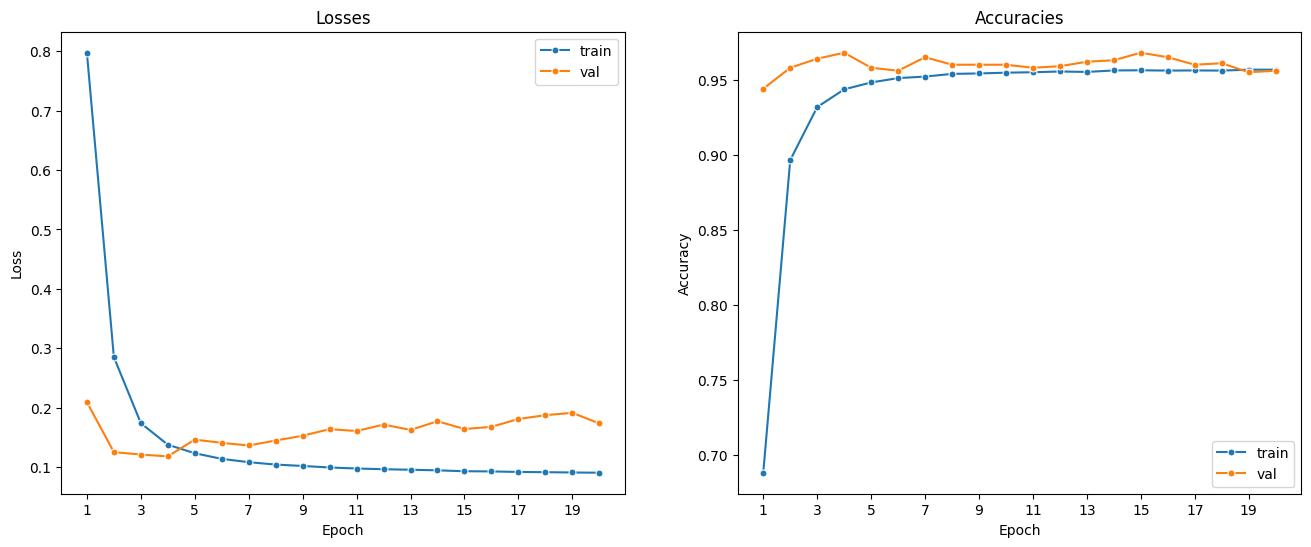

<Figure size 640x480 with 0 Axes>

In [ ]:
import seaborn as sns

data_1 = pd.DataFrame({'x': epochs, 'y': train_losses})
data_2 = pd.DataFrame({'x': epochs, 'y': val_losses})

data_3 = pd.DataFrame({'x': epochs, 'y': train_accuracies})
data_4 = pd.DataFrame({'x': epochs, 'y': val_accuracies})


fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.lineplot(data=data_1, x='x', y='y', marker='o', markersize=5, label='train', ax=axes[0])
sns.lineplot(data=data_2, x='x', y='y', marker='o', markersize=5, label='val', ax=axes[0])
axes[0].set_title("Losses")
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_xticks(epochs[::2])

sns.lineplot(data=data_3, x='x', y='y', marker='o', markersize=5, label='train', ax=axes[1])
sns.lineplot(data=data_4, x='x', y='y', marker='o', markersize=5, label='val', ax=axes[1])
axes[1].set_title("Accuracies")
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("Accuracy")
axes[1].set_xticks(epochs[::2])

plt.show()
plt.tight_layout();

## Визуализация весов модели

In [ ]:
matr_names = ["Wq", "Wk", "Wv", "Wi", "Wf", "Wo"]
matrs = [getattr(model.xlstm.layers[0], matr_name).weight.data.cpu().numpy() for matr_name in matr_names]

fig, axes = plt.subplots(len(matr_names), 2, figsize=(16, 6))

for i in range(len(matr_names)):
    sns.heatmap(matrs[i], ax=axes[i, 0], cmap='RdBu_r', center=0,
                   xticklabels=False, yticklabels=False)
    axes[i, 0].set_title('Weights Heatmap')

    sns.kdeplot(matrs[i].flatten(), ax=axes[i, 1], fill=True, alpha=0.7, color='skyblue')
    axes[i, 1].set_title('Weights Distribution')


# Выводы

В данной работе представлена попытка обучения xLSTM для решения задачи классификации (тональность поста в twitter).

Помимо стандртных процедур сборки данных и обучения, использовался хитрый приём для отбора лучших моделей: сохранялись лишь те модели, которые превосходили результаты обучения на предыдущих эпохах.

Архитектура модели, заточенная под последовательные данные, показала себя хорошо, что заметно по графикам обучения.